<a href="https://colab.research.google.com/github/AgnieszkaBorys/data-science-bootcamp/blob/master/ml2206_03_sn_overfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
# komponenty do budowania sieci
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout 

from tensorflow.random import set_seed
set_seed(0)

In [4]:
df_train = pd.read_csv('http://hackingpython.pl/ML2206/Day04/train.csv')
df_train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,-0.443,-0.338,0.416,-2.177,-0.326,0.340,1.174,-0.245,-1.070,-0.336,-0.502,0.403,-0.605,-0.280,-1.618,0.878,-0.272,0.870,2.171,-0.214,0.477,-2.092,0.835,0.621,-2.810,1.029,-0.736,0.582,-0.079,0.493,...,0.055,1.107,-0.848,-1.781,0.254,-0.515,0.234,0.296,-1.774,2.032,-0.442,-0.116,1.393,-0.494,-0.179,1.874,1.463,-1.397,0.284,0.336,0.551,0.557,-0.522,-0.503,-0.541,1.393,0.506,-1.420,-0.123,-1.833,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,0.557,1.202,0.542,0.424,-1.572,-0.968,-1.483,0.564,0.047,-0.324,-1.490,0.179,-0.524,0.250,2.462,0.029,-1.399,-2.370,-1.505,-1.294,0.106,-0.145,0.235,-1.045,1.335,1.254,-0.811,1.812,0.181,-0.020,...,0.627,-1.472,0.496,-0.052,0.322,-0.222,1.168,0.931,-0.203,0.321,0.761,1.752,0.181,-3.029,-0.578,-0.260,-0.425,-0.160,-0.497,-0.049,1.097,0.398,0.554,0.578,-0.544,0.441,-0.524,-1.474,-0.090,-0.607,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,-0.624,-0.017,-0.665,1.905,0.376,-1.373,1.587,1.464,-1.550,-0.512,0.508,-0.094,-0.114,-0.425,0.104,0.643,-1.371,1.553,-0.062,-0.173,-0.465,-1.252,0.443,2.205,-1.266,-0.739,0.827,-1.306,0.274,-1.573,...,-1.610,-0.801,1.557,0.628,-0.072,-0.573,0.507,-1.229,0.313,1.446,-0.345,1.147,-0.623,-0.048,1.456,-0.932,0.666,0.451,0.671,-0.596,-0.135,0.966,-0.167,0.530,-1.493,-0.917,0.120,0.258,-0.405,-0.859,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,-0.118,-0.638,0.760,-0.360,-2.048,-0.996,-0.361,0.962,0.021,0.595,-0.943,0.069,0.483,-0.063,-0.540,-0.551,-1.736,-2.014,0.636,-1.147,-0.767,-0.678,0.815,1.696,-0.436,-1.777,0.548,0.318,0.978,1.299,...,0.011,1.137,0.499,-0.262,-1.484,0.216,-2.536,0.191,-0.142,1.387,-1.617,-0.662,-2.288,-1.130,0.651,-0.363,0.686,-0.504,1.734,-0.606,0.514,-0.506,-1.294,0.382,-1.119,1.695,-0.775,-1.428,0.231,-0.780,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,-0.656,-0.499,-0.653,-0.058,-0.046,0.654,-0.697,-1.175,0.720,0.484,0.402,-1.037,1.081,0.716,-0.144,1.720,-1.980,-0.741,-1.493,-0.860,-0.082,0.133,1.084,-0.719,0.198,1.144,1.123,0.435,-0.296,-2.933,...,0.285,-0.464,1.427,0.554,-0.131,-1.425,0.487,0.413,-0.231,1.570,-0.714,0.385,-0.072,0.150,-0.228,0.144,-1.537,0.664,-0.133,0.424,0.926,-0.089,-0.415,0.299,-1.227,-2.578,0.600,2.167,-0.755,-1.265,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


In [5]:
df_train.shape

(250, 302)

In [7]:
X = df_train.iloc[:, 2:]
y = df_train.target.astype('int')

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# tworzenie sieci
model = Sequential()
model.add( Dense(300, activation='relu', input_dim=300 ) )   #pierwszy arg to liczba neuronów w warstwie, nie musi być takie samo jak liczba cech, input_dim - ile cech ma zmienna wejściowa X
model.add( Dense(128, activation='relu') )
model.add( Dense(64, activation='relu') )
model.add( Dense(1, activation='sigmoid'))  #warstwa wyjsciowa, tutaj podajemy 1, bo zmienna y jest binarna wystarczy 1 aby zdefiniiwać wynik

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )  #typowe wartości dla problemu kategoryzacji (tutaj 10 wartośi zm y bo cyfry)

result = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test), batch_size=32 )

In [11]:
result.history.keys()  #zmienna val to validacja modelu czyli wyniki policzone na dancyh testowych

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [12]:
df = pd.DataFrame( result.history)

In [13]:
df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.624789,0.680,0.544325,0.76
1,0.339985,0.860,0.540462,0.76
2,0.206550,0.975,0.563693,0.76
3,0.114900,0.995,0.602429,0.72
4,0.056349,1.000,0.654622,0.72


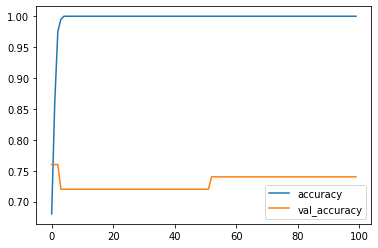

In [14]:
df[['accuracy', 'val_accuracy']].plot()

Wniosek: model swietnie liczy dla danych trningowych ale nie bardzo dla testowych. To nie jest dobre - ma działąć na danych rzeczywistych. Wykresy powinny być zbliżone.

# Modyfikacja ilości neuronów i warstw

In [22]:
import tensorflow as tf

In [25]:
# tworzenie sieci
model = Sequential()
model.add( Dense(16, activation='relu', input_dim=300 ) )   #pierwszy arg to liczba neuronów w warstwie, nie musi być takie samo jak liczba cech, input_dim - ile cech ma zmienna wejściowa X
model.add( Dropout(0.4) )  #usuwa 40% neuronów wybranych losowo 

model.add( Dense(8, activation='relu') )
model.add( Dropout(0.2) )

model.add( Dense(1, activation='sigmoid'))  #warstwa wyjsciowa, tutaj podajemy 1, bo zmienna y jest binarna wystarczy 1 aby zdefiniiwać wynik

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )  #typowe wartości dla problemu kategoryzacji (tutaj 10 wartośi zm y bo cyfry)

# wrzucamy funkcję ktora zatrzymuje nam wykonanie kolejnej epoki, trigerem jest 'val_loss', patience=3 oznacza ze nie zmienila sie ta wartosc przez 3 epoki. TO zapobiega przeuczeniu sieci 
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)  
result = model.fit(X_train, y_train, epochs=300, verbose=0, validation_data=(X_test, y_test), batch_size=32, callbacks=[es_callback] )

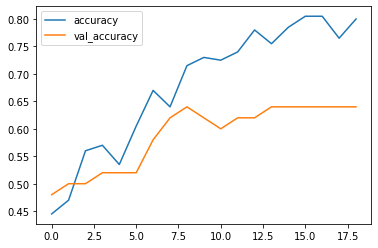

In [26]:
df = pd.DataFrame( result.history)
df[['accuracy', 'val_accuracy']].plot()

# Wybór najlepszych cech

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif

In [29]:
selected = SelectKBest(f_classif, k = 10)  #redukcja do k najlepszych wymiarów
selected_features = selected.fit_transform(X, y)
selected_features.shape

(250, 10)

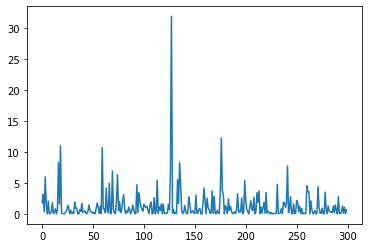

In [33]:
# uwaga tutaj kolumny mają numery, gdy mają nazwy trzeba dodać indeksację
pd.Series(selected.scores_).plot()

In [34]:
# tworzenie sieci
model = Sequential()
model.add( Dense(16, activation='relu', input_dim=selected_features.shape[1] ) )   # input_dim - odwoluje się do liczby kol w zestawie wybranych kolumn
model.add( Dropout(0.4) )  #usuwa 40% neuronów wybranych losowo 

model.add( Dense(8, activation='relu') )
model.add( Dropout(0.2) )

model.add( Dense(1, activation='sigmoid'))  #warstwa wyjsciowa, tutaj podajemy 1, bo zmienna y jest binarna wystarczy 1 aby zdefiniiwać wynik

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )  #typowe wartości dla problemu kategoryzacji (tutaj 10 wartośi zm y bo cyfry)

# wrzucamy funkcję ktora zatrzymuje nam wykonanie kolejnej epoki, trigerem jest 'val_loss', patience=3 oznacza ze nie zmienila sie ta wartosc przez 3 epoki. TO zapobiega przeuczeniu sieci 
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)  

#uwaga: tutaj podajemy cały zestaw danych i robimy splikn atrain test  bezpośrednio w metodzie (bez train test split),  
result = model.fit(selected_features, y, epochs=300, verbose=0, validation_split=0.2, batch_size=32, callbacks=[es_callback] )

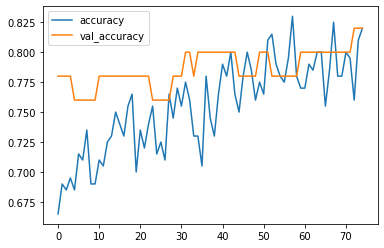

In [35]:
df = pd.DataFrame( result.history)
df[['accuracy', 'val_accuracy']].plot()

Wniosek: po selekcji zmiennych wyszedł idealny wykres, czyli train i test accuracy są wysokie i nie odbiegają istotnie od siebie